In [51]:
%matplotlib inline
%load_ext autoreload
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from matplotlib import rc
from tqdm import tqdm_notebook as tqdm

rc("font", family = "serif",size=20)
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'

import cvxpy as cp
import numpy as np

%autoreload 2
from loss import *
from reg import *
from convergence import *
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#if i don't run this twice it doesn't work?

rc("font", family = "serif",size=20)
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")

## Qs

Revaluating the same problem instead of creating it each time.

## Defining Classes of Loss and Regularizer

Taken from: https://github.com/powerscorinne/GLRM

## load iris data

In [3]:
iris = datasets.load_iris()
sk_scaler = StandardScaler()
sk_scaler.fit(iris.data)
A = sk_scaler.transform(iris.data)
# A = StandardScaler().fit_transform(iris.data)

y = iris.target
cols = np.array(['tab:blue','tab:orange','tab:green'])[y]

## Do nonregularized PCA

0
1
done


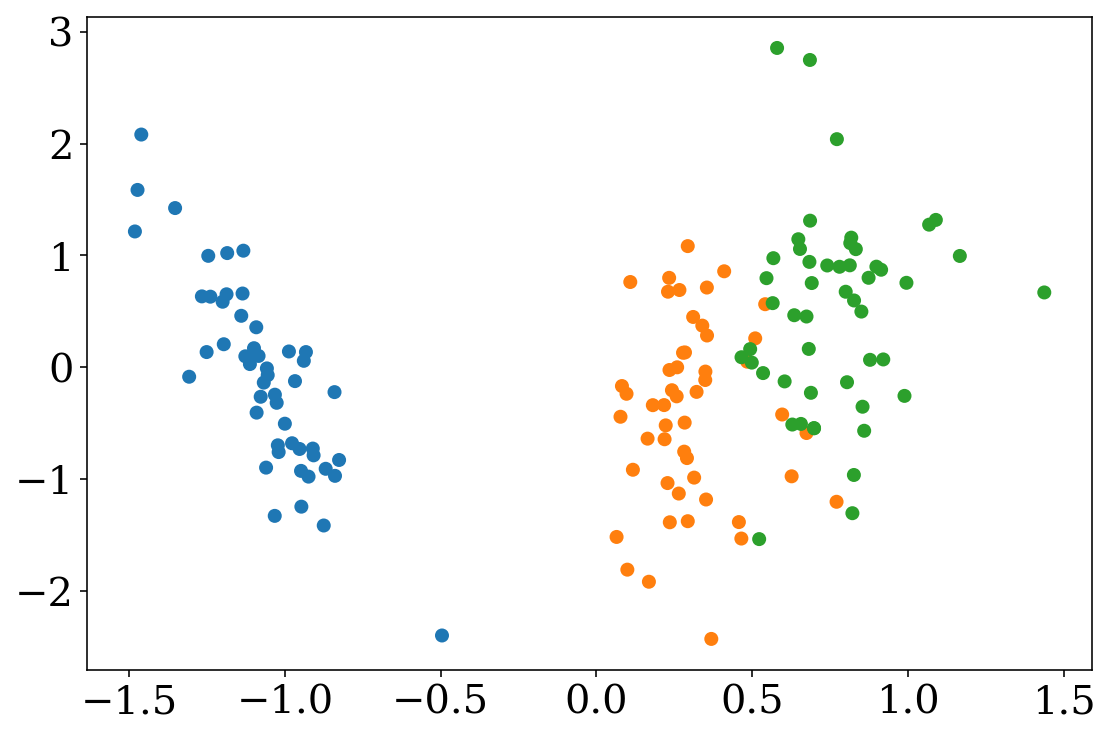

In [4]:
k = 2


m,n = A.shape
# A = np.random.randn(m, n)
Xp = cp.Parameter((m,k))
Yp = cp.Parameter((k,n))

Xv = cp.Variable((m,k))
Yv = cp.Variable((k,n))
X0 = np.random.rand(m,k)



#Random Intialization 
Xv.value = np.random.rand(m,k)
Xp.value = np.random.rand(m,k)

Yp.value = np.random.rand(k,n)
Yv.value = np.random.rand(k,n)

niter = 2
for i in range(niter):
    print(i)
    
    # do X
    objX = cp.Minimize(cp.sum_squares(A-Xv@Yp))
    probX = cp.Problem(objX)
    probX.solve(verbose=False)

    Xp.value = Xv.value
#     Yp = np.random.rand(k,n)
    # do Y
    objY = cp.Minimize(cp.sum_squares(A-Xp@Yv))
    probY = cp.Problem(objY)
    probY.solve()
    Yp.value = Yv.value
print("done")

X = Xp.value
plt.scatter(X[:,0],X[:,1],color=cols)

Not redefining the problem evey time

0
1
done


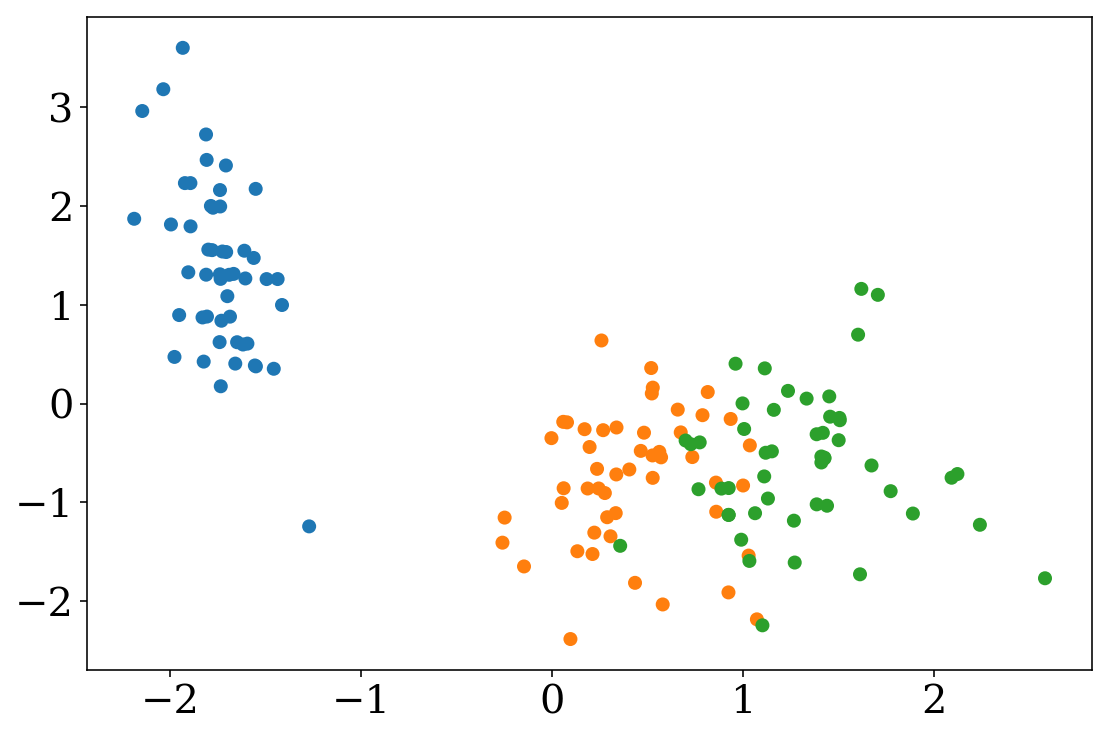

In [5]:
k = 2


m,n = A.shape
# A = np.random.randn(m, n)
Xp = cp.Parameter((m,k))
Yp = cp.Parameter((k,n))

Xv = cp.Variable((m,k))
Yv = cp.Variable((k,n))
X0 = np.random.rand(m,k)



#Random Intialization 
Xv.value = np.random.rand(m,k)
Xp.value = np.random.rand(m,k)

Yp.value = np.random.rand(k,n)
Yv.value = np.random.rand(k,n)

objX = cp.Minimize(cp.sum_squares(A-Xv@Yp))
probX = cp.Problem(objX)
objY = cp.Minimize(cp.sum_squares(A-Xp@Yv))
probY = cp.Problem(objY)

niter = 2
for i in range(niter):
    print(i)
    
    # do X
    probX.solve(verbose=False)
    Xp.value = Xv.value

    # do Y
    probY.solve()
    Yp.value = Yv.value
print("done")

X = Xp.value
plt.scatter(X[:,0],X[:,1],color=cols)

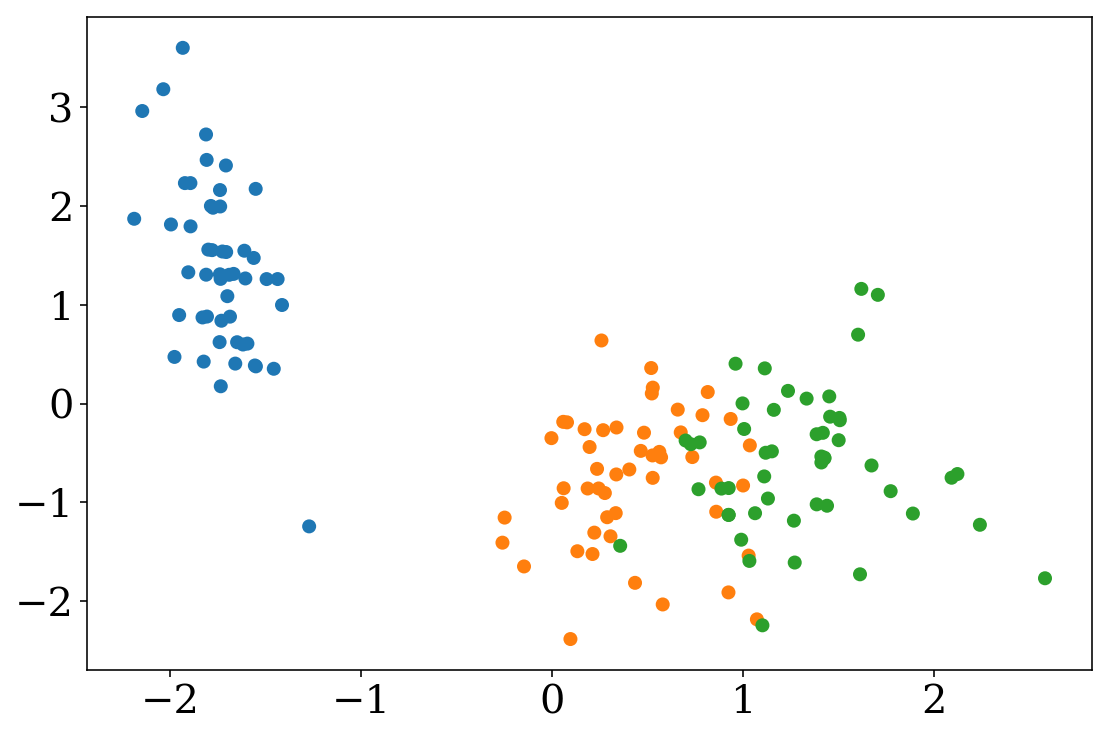

In [6]:
X = Xp.value
plt.scatter(X[:,0],X[:,1],color=cols)

## Works great. Now regularized PCA

But the Y problem sometimes hangs if i don't pass it max_iters???? - this was true when i was using LinearReg  instead of QuadraticReg


up to 

In [7]:
k = 2

#define a regularizer
# use one for X and one for Y for generality

regX = QuadraticReg(nu=.1)
regY = QuadraticReg(nu=.1)
#Reinitialize 
Xv.value = np.random.rand(m,k)
Xp.value = np.random.rand(m,k)

Yp.value = np.random.rand(k,n)
Yv.value = np.random.rand(k,n)


objX = cp.Minimize(cp.sum_squares(A-Xv@Yp)+regX(Xv))
probX = cp.Problem(objX)

objY = cp.Minimize(cp.sum_squares(A-Xp@Yv)+regY(Yv))
probY = cp.Problem(objY)

niter = 7
max_iter = 1000
for i in range(niter):
    print(i)
    
    # do X
 
    probX.solve(verbose=False)

    Xp.value = Xv.value
    # do Y
    print('here')
    probY.solve(verbose=False)
    Yp.value = Yv.value
print("done")

0
here
1
here
2
here
3
here
4
here
5
here
6
here
done


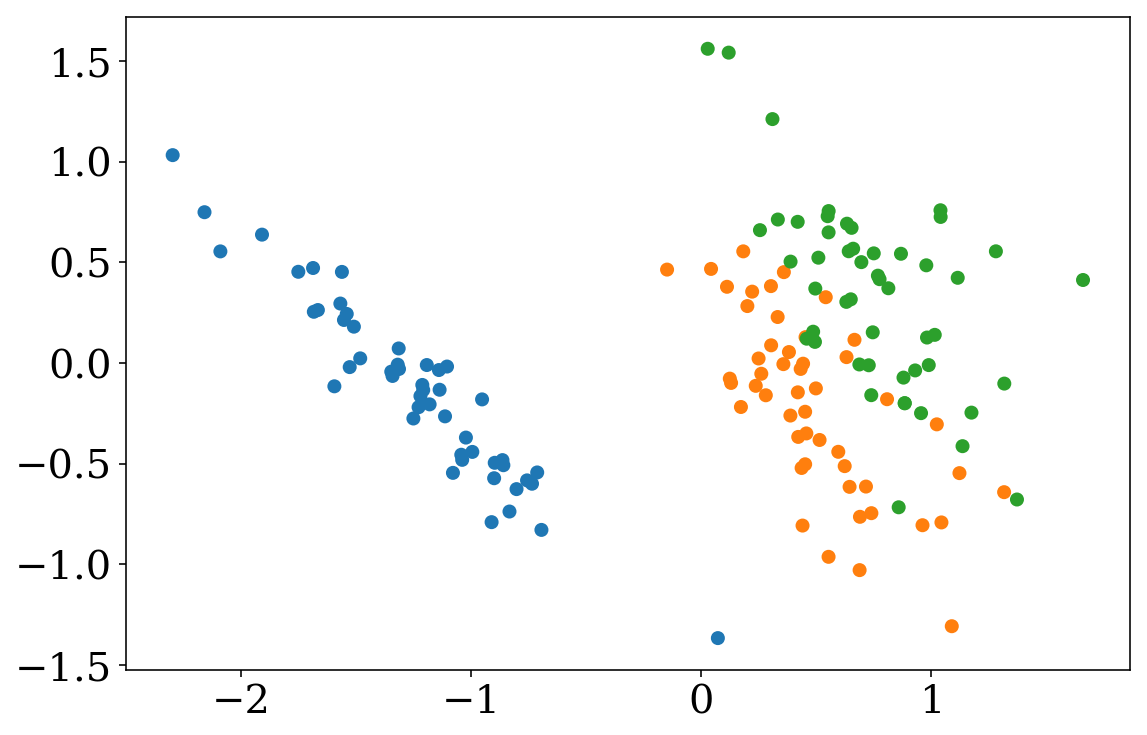

In [8]:
X = Xp.value
plt.scatter(X[:,0],X[:,1],color=cols)

## Now with missing data :O

Can mask away the missing data points at two different times.

1. Calc XY and then don't compare to missing points
2. don't even calculate the missing values

Option 2 is likely more efficient if implemented well but option 1 will be much clearer. I think my confusion with the existing implementation is partially a consequence of their usage of option 2


I did that with masking. But sometimes the imputed value for a point will just be absolutely huge???

This definitely happens more often when I have more than one missing data point in a row. I changed the missing_idx to prevent that in this case.

Could instead be:

`missing_idx =np.random.randint(0.150,size=(n_missing,1))`


In [9]:
n_missing = 50
missing_idx =np.random.choice(np.arange(150),size=(n_missing,1),replace=False)

missing_idx =np.hstack([missing_idx,np.random.randint(0,4,size=(n_missing,1))])
row = missing_idx[:,0]
col = missing_idx[:,1]
mask = np.zeros_like(A)

mask[missing_idx[:,0],missing_idx[:,1]]=1
mask = ~mask.astype(np.bool)


In [10]:
k = 2


m,n = A.shape
# A = np.random.randn(m, n)
Xp = cp.Parameter((m,k))
Yp = cp.Parameter((k,n))

Xv = cp.Variable((m,k))
Yv = cp.Variable((k,n))
X0 = np.random.rand(m,k)



#Random Intialization 
Xv.value = np.random.rand(m,k)
Xp.value = np.random.rand(m,k)

Yp.value = np.random.rand(k,n)
Yv.value = np.random.rand(k,n)

niter = 20


for i in range(niter):
#     print(i)
    # do X
    objX = cp.Minimize(cp.sum_squares((A-Xv@Yp)[mask]))
    probX = cp.Problem(objX)
    probX.solve(verbose=False)

    Xp.value = Xv.value
#     Yp = np.random.rand(k,n)
    # do Y
    objY = cp.Minimize(cp.sum_squares((A-Xp@Yv)[mask]))
    probY = cp.Problem(objY)
    probY.solve()
    Yp.value = Yv.value
print("done")

done


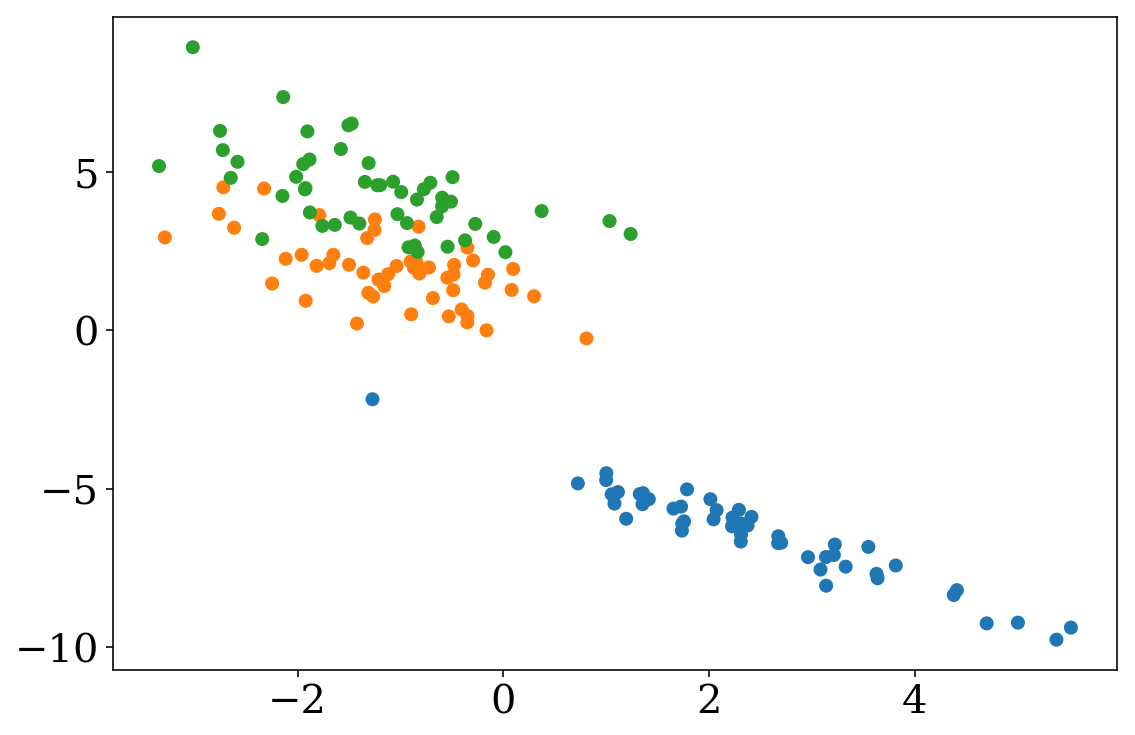

In [11]:
X = Xp.value
plt.scatter(X[:,0],X[:,1],color=cols)


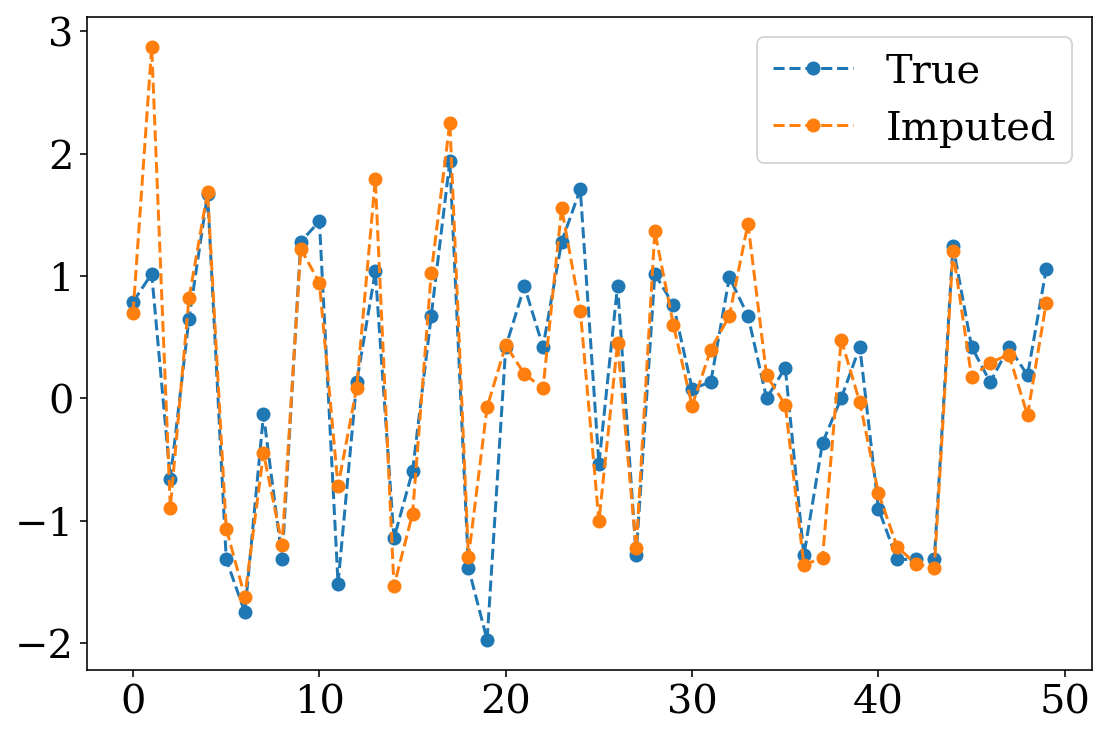

In [12]:
plt.plot(A[row,col],'o--',label='True')
plt.plot((Xp@Yp).value[row,col],'o--',label='Imputed')
plt.legend()
plt.show()

## Mixed Data + loss function based scaling

I think I'll start easy by making the final column of the data matrix a categorical of the flower class

Plan is to keep a list of columns and the associated loss function. Maybe tuples like:
`[([columns],Loss Function),([columns],Loss Function),....]`  

gotta figure out how to do the loss function normalization. See sections 2.6, 3.3 and 4.4


You can do some wacky stuff with the regularizers adding acolumn of ones to X to create the offset, but its not clear to me why or even if that is a better thing to do than just actually subtracting the offset?

need to modify the loss function to take a mask - or just pass them the masked things

Figure out adding offsets and scaling

 From CVXPY documentioan (https://buildmedia.readthedocs.org/media/pdf/cvxpy/latest/cvxpy.pdf) pg 104:
 
 Indexing and other operations can map 2D expressions down to 1D or 0D expressions.  For example, ifXhasshape(3, 2), thenX[:,0]has shape(3,). CVXPY behavior follows NumPy semantics in all cases, withthe exception that broadcasting only works when one argument is 0D.
 
 
 So broadcasting doesn't totally do :(
 
 need to be careful that when calcualting the mus not setting the other ones to zero. it sems like the solver does this natural. add constraint?

In [13]:
#really should be one vs many loss here
Amix = np.hstack([np.copy(iris.data),iris.target[:,None]])
idx = Amix[:,-1]<1.5
Amix[:,-1][idx] =1
Amix[:,-1][~idx]=-1
mask2  =np.hstack([mask,np.ones([150,1]).astype(np.bool)]) # extra column of missing data


In [47]:
n_missing = 50
missing_idx =np.random.choice(np.arange(150),size=(n_missing,1),replace=False)

missing_idx =np.hstack([missing_idx,np.random.randint(0,5,size=(n_missing,1))])
row = missing_idx[:,0]
col = missing_idx[:,1]
mask = np.zeros_like(Amix)

mask[missing_idx[:,0],missing_idx[:,1]]=1
mask = ~mask.astype(np.bool)



loss_list = [(np.array([0,1,2,3]),QuadraticLoss(mask=mask)),
             (np.array([4]),HingeLoss(mask=mask))]


In [50]:
ones = cp.Constant(np.ones([Amix.shape[0],1]))
mu = cp.Variable((1,Amix.shape[1]))
mu.value = np.array([[1,2,3,4,5]])


arr = ones @ mu
sigma_arr = np.ones_like(Amix)
#Calc mu
constraints = []
for columns, loss_fxn in loss_list:
    obj = cp.Minimize(loss_fxn(Amix,arr,columns))
    prob =cp.Problem(obj,constraints=constraints)
#     print(prob.solve())
    constraints.append(mu[:,columns]==mu[:,columns].value)
    
#calc sigma
sigma = np.zeros(Amix.shape[1])
for i in range(len(loss_list)):
    for j in loss_list[i][0]:
#         print(columns)
#         print('outside',sigma_arr.shape)
#         print(loss_fxn)
        msk = mask[:,j]
        columns = loss_list[i][0]
        print(loss_list[i][1](Amix,arr,np.array([j])).value)
        sigma[j] = loss_list[i][1](Amix,arr,np.array([j])).value
nj = mask.sum(axis=0)
sigma /= (nj-1)
sigma

3392.7799999999997
181.44
523.69
1152.48
1728.0


array([24.40848921,  1.32437956,  3.79485507,  8.29122302, 12.16901408])

(array([[5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857, 3.06231884, 3.82517986, 1.23142857, 0.32867133],
        [5.85142857,

### PCA with loss function based scaling

below is a nice example of regularization beign useful

it also shows how useful a convergence object is.

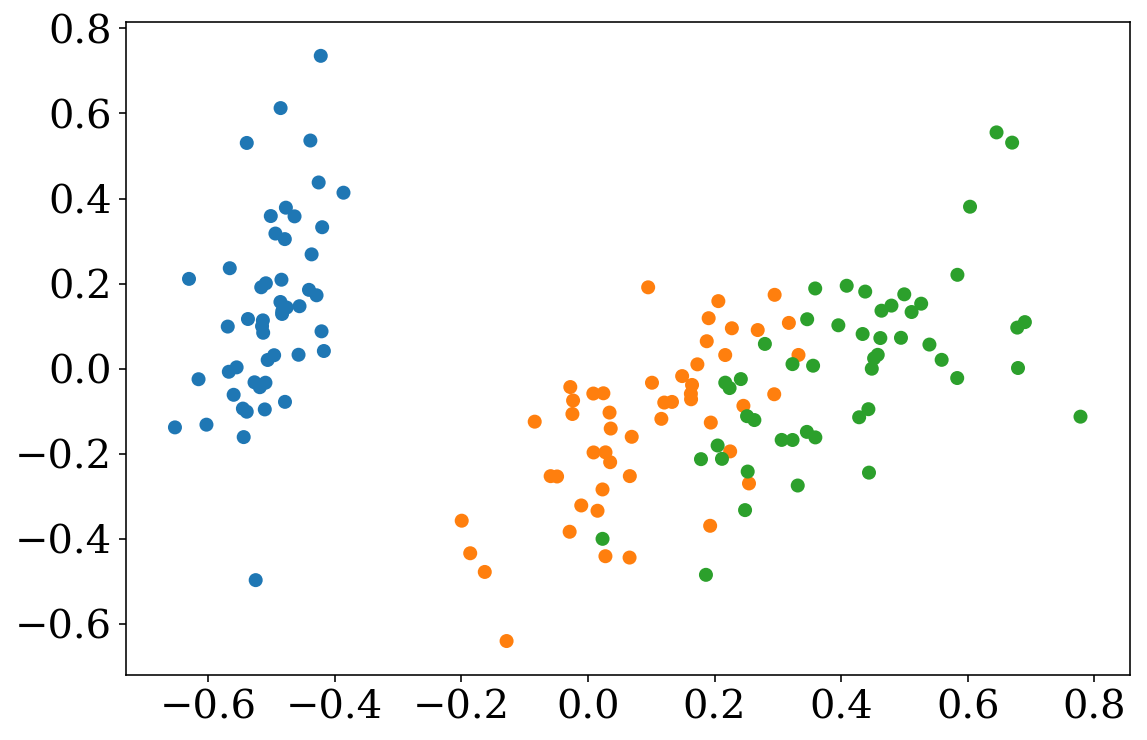

In [45]:
mu_arr= np.ones([150,1]) @ mu
sigma_arr = np.ones([150,1]) @ sigma[None,:]

columns = np.arange(4)

k = 2
m,n = Amix.shape
# A = np.random.randn(m, n)
Xp = cp.Parameter((m,k))
Yp = cp.Parameter((k,n))

Xv = cp.Variable((m,k))
Yv = cp.Variable((k,n))
X0 = np.random.rand(m,k)



#Random Intialization 
Xv.value = np.random.rand(m,k)
Xp.value = np.random.rand(m,k)

Yp.value = np.random.rand(k,n)
Yv.value = np.random.rand(k,n)
# Qloss = ScaledQuadraticLossQuadraticLoss()

Qreg = QuadraticReg()
scaled_Qloss = ScaledQuadraticLoss(mask=mask)
niter = 6
for i in tqdm(range(niter)):
#     print(i)
    # could have a loop over loss-list here
    # do X
    scaled_Qloss(Amix,Xv@Yp,columns,sigma_arr)
    objX = cp.Minimize(scaled_Qloss(Amix-mu_arr,Xv@Yp,columns,sigma_arr)+Qreg(Xv))
    probX = cp.Problem(objX)
    probX.solve(verbose=False)

    Xp.value = Xv.value

    # do Y
    objY = cp.Minimize(scaled_Qloss(Amix-mu_arr,Xp@Yv,columns,sigma_arr))
    probY = cp.Problem(objY)
    probY.solve()
    Yp.value = Yv.value
# print("done")

X = Xp.value
plt.scatter(X[:,0],X[:,1],color=cols)

## PCA with mixed data types

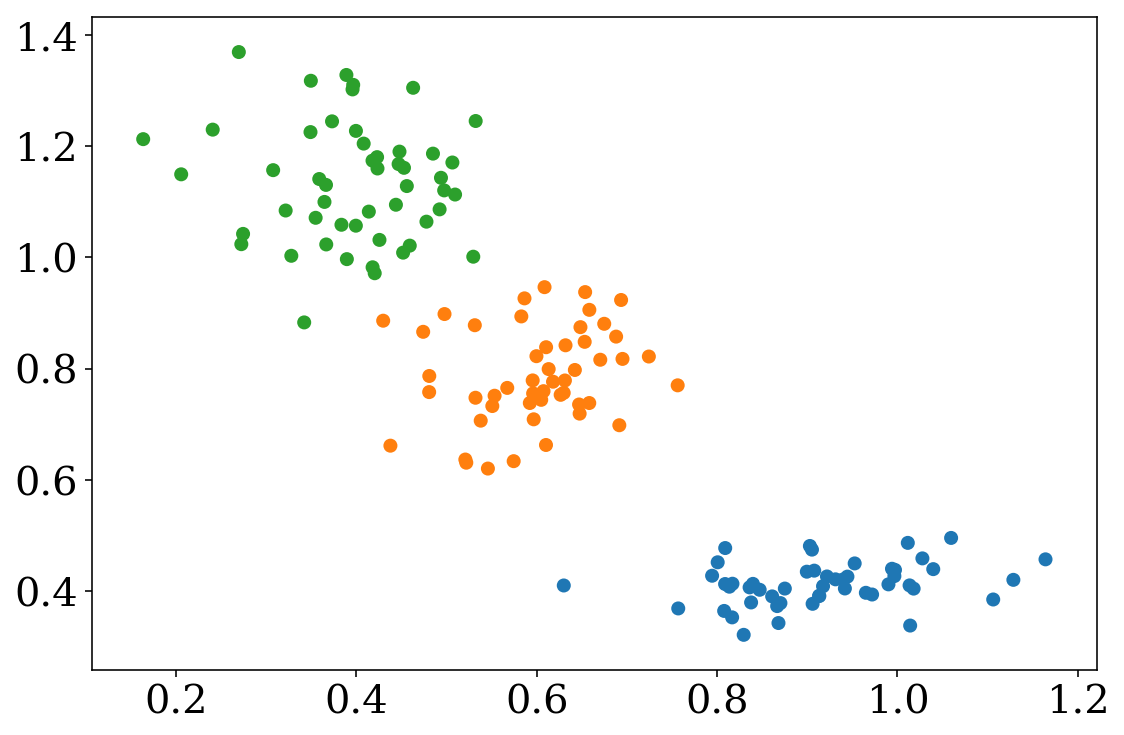

In [17]:
loss_list = [(np.arange(4),ScaledQuadraticLoss(mask)),
             (np.array([-1]), ScaledHingeLoss(mask))]

mask = np.copy(mask2)
mu_arr= np.ones([150,1]) @ mu
sigma_arr = np.ones([150,1]) @ sigma[None,:]

columns = np.arange(4)

k = 2
m,n = Amix.shape
# A = np.random.randn(m, n)
Xp = cp.Parameter((m,k))
Yp = cp.Parameter((k,n))

Xv = cp.Variable((m,k))
Yv = cp.Variable((k,n))
X0 = np.random.rand(m,k)



#Random Intialization 
Xv.value = np.random.rand(m,k)
Xp.value = np.random.rand(m,k)

Yp.value = np.random.rand(k,n)
Yv.value = np.random.rand(k,n)
Qloss = ScaledQuadraticLoss(mask=mask)

Qreg = QuadraticReg()
niter = 6
objX = cp.Constant(0)
objY = cp.Constant(0)

#define objectives
for columns, loss_fxn in loss_list:
    objX += loss_fxn(Amix,Xv@Yp,columns,sigma_arr)       
    objY += loss_fxn(Amix,Xp@Yv,columns,sigma_arr)
if regX is not None:
    objX += Qreg(Xv)
if regY is not None:
    objY += regY(Yv)
objX = cp.Minimize(objX)
objY = cp.Minimize(objY)
probX = cp.Problem(objX)

probY = cp.Problem(objY)
losses = []
niter = 100
for i in tqdm(range(niter)):
#     print(i)
    # could have a loop over loss-list here
    # do X
    
    losses.append(probX.solve(verbose=False))

    Xp.value = Xv.value

    # do Y

    
    losses.append(probY.solve())
    Yp.value = Yv.value
# print("done")

X = Xp.value
Y = Yp.value
Z = X @ Y
plt.scatter(X[:,0],X[:,1],color=cols)
plt.show()

In [18]:
cp.huber(np.arange(6).reshape(3,2)).value

array([[0., 1.],
       [3., 5.],
       [7., 9.]])

## Adding in convergence object


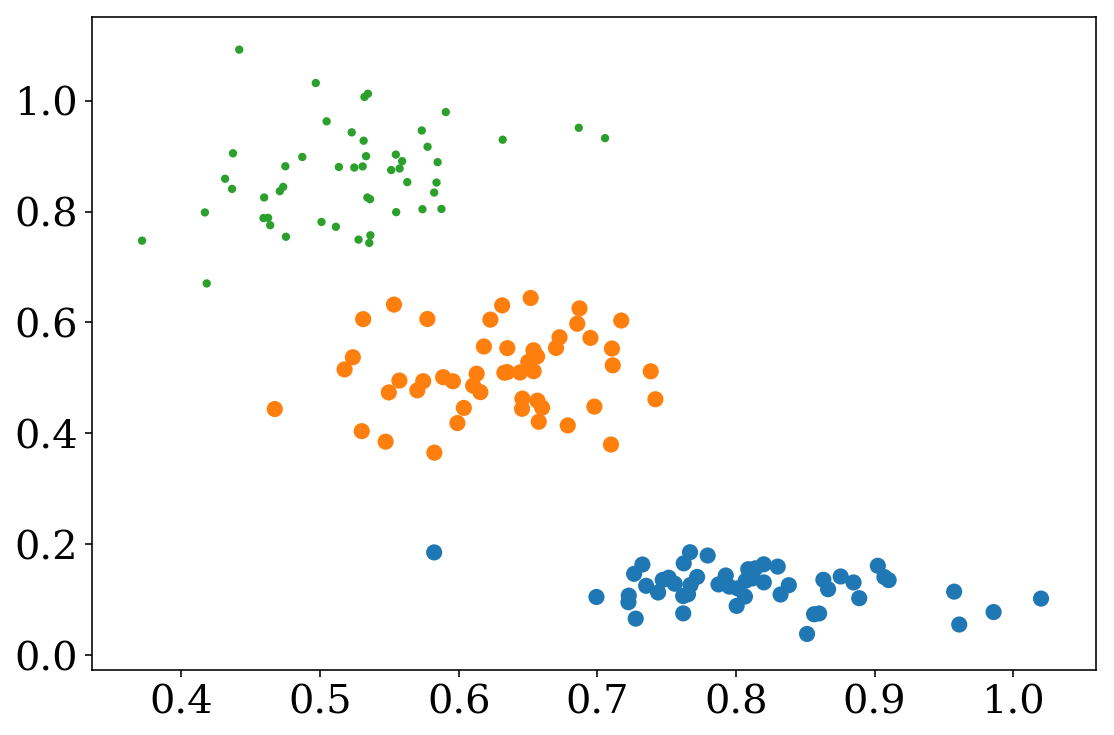

In [42]:
loss_list = [(np.arange(4),ScaledQuadraticLoss(mask)),
             (np.array([-1]), ScaledHingeLoss(mask))]

mask = np.copy(mask2)
mu_arr= np.ones([150,1]) @ mu
sigma_arr = np.ones([150,1]) @ sigma[None,:]

columns = np.arange(4)

k = 2
m,n = Amix.shape
# A = np.random.randn(m, n)
Xp = cp.Parameter((m,k))
Yp = cp.Parameter((k,n))

Xv = cp.Variable((m,k))
Yv = cp.Variable((k,n))
X0 = np.random.rand(m,k)



#Random Intialization 
Xv.value = np.random.rand(m,k)
Xp.value = np.random.rand(m,k)

Yp.value = np.random.rand(k,n)
Yv.value = np.random.rand(k,n)
Qloss = ScaledQuadraticLoss(mask=mask)
convergence = Convergence(TOL=1e-6)
Qreg = QuadraticReg()
niter = 6
objX = cp.Constant(0)
objY = cp.Constant(0)

#define objectives
for columns, loss_fxn in loss_list:
    objX += loss_fxn(Amix,Xv@Yp,columns,sigma_arr)       
    objY += loss_fxn(Amix,Xp@Yv,columns,sigma_arr)
if regX is not None:
    objX += Qreg(Xv)
if regY is not None:
    objY += regY(Yv)

probX = cp.Problem(objX)

probY = cp.Problem(objY)
losses = []
niter = 100
while not convergence:
#     print(i)
    # could have a loop over loss-list here
    # do X
    
    convergence.append('x',probX.solve(verbose=False))

    Xp.value = Xv.value

    # do Y

    
    convergence.append('y',probY.solve())
    Yp.value = Yv.value
# print("done")

X = Xp.value
Y = Yp.value
Z = X @ Y
plt.scatter(X[:,0],X[:,1],color=cols,s=20*(Amix[:,-1]+1.5))
plt.show()

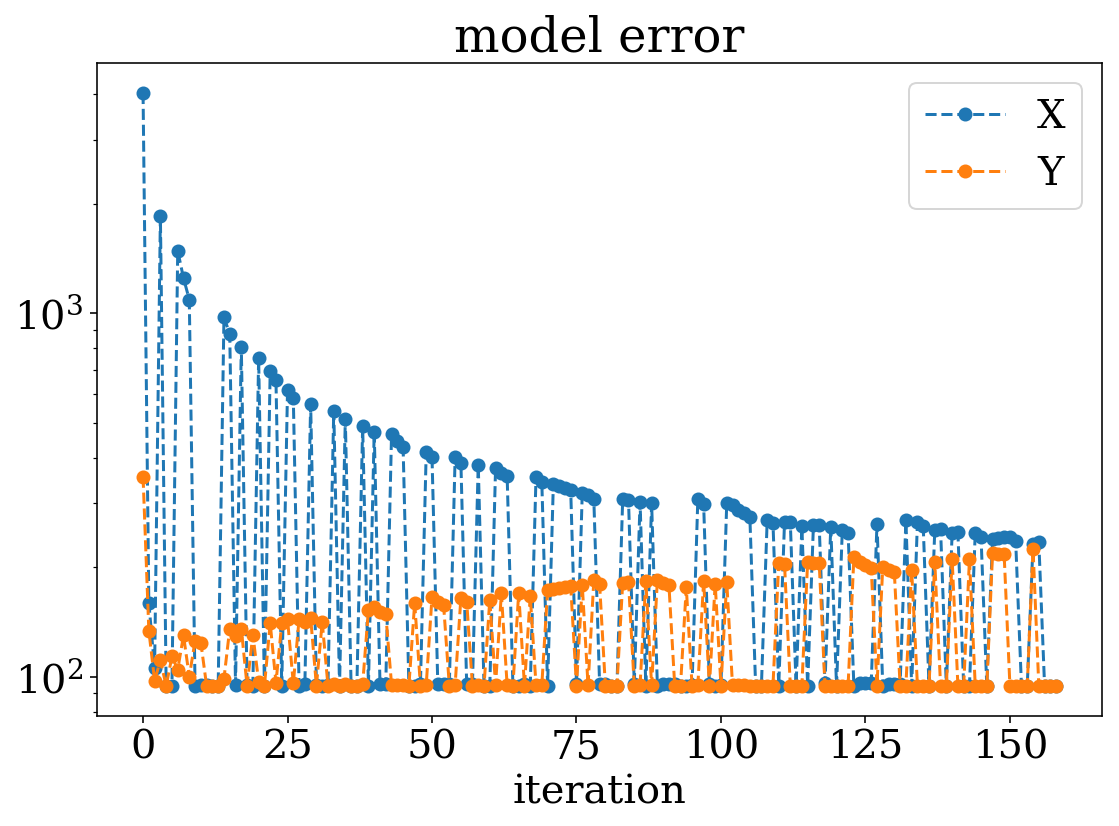

In [43]:
convergence.plot(show=False)
plt.yscale('log')

In [21]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
print(X.shape)
pca = PCA(n_components=2)
X = pca.fit_transform(X)


print(pca.explained_variance_ratio_)  

print(pca.singular_values_) 

(6, 2)
[0.99244289 0.00755711]
[6.30061232 0.54980396]


In [22]:
sk_scaler.fit(Amix)
X = sk_scaler.transform(Amix)
U,s,V = np.linalg.svd(X,full_matrices=False)

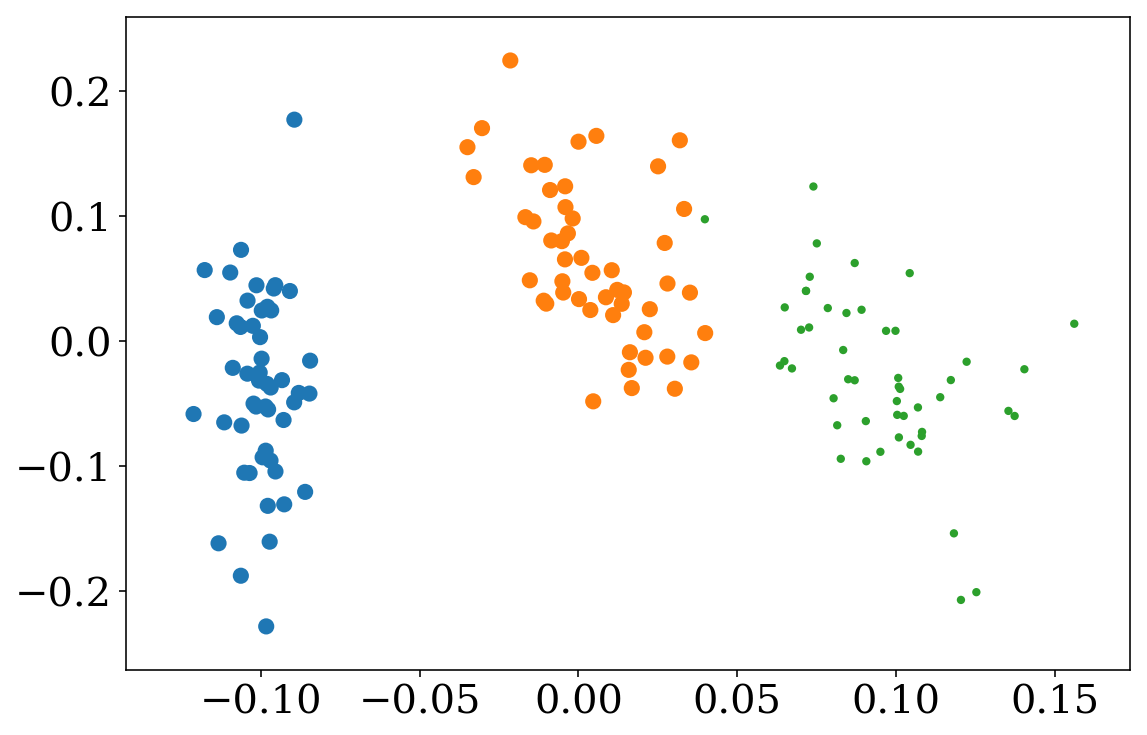

In [37]:
plt.scatter(U[:,0],U[:,1],s=20*(Amix[:,-1]+1.5),color = cols)

In [25]:
Amix

array([[ 5.1,  3.5,  1.4,  0.2,  1. ],
       [ 4.9,  3. ,  1.4,  0.2,  1. ],
       [ 4.7,  3.2,  1.3,  0.2,  1. ],
       [ 4.6,  3.1,  1.5,  0.2,  1. ],
       [ 5. ,  3.6,  1.4,  0.2,  1. ],
       [ 5.4,  3.9,  1.7,  0.4,  1. ],
       [ 4.6,  3.4,  1.4,  0.3,  1. ],
       [ 5. ,  3.4,  1.5,  0.2,  1. ],
       [ 4.4,  2.9,  1.4,  0.2,  1. ],
       [ 4.9,  3.1,  1.5,  0.1,  1. ],
       [ 5.4,  3.7,  1.5,  0.2,  1. ],
       [ 4.8,  3.4,  1.6,  0.2,  1. ],
       [ 4.8,  3. ,  1.4,  0.1,  1. ],
       [ 4.3,  3. ,  1.1,  0.1,  1. ],
       [ 5.8,  4. ,  1.2,  0.2,  1. ],
       [ 5.7,  4.4,  1.5,  0.4,  1. ],
       [ 5.4,  3.9,  1.3,  0.4,  1. ],
       [ 5.1,  3.5,  1.4,  0.3,  1. ],
       [ 5.7,  3.8,  1.7,  0.3,  1. ],
       [ 5.1,  3.8,  1.5,  0.3,  1. ],
       [ 5.4,  3.4,  1.7,  0.2,  1. ],
       [ 5.1,  3.7,  1.5,  0.4,  1. ],
       [ 4.6,  3.6,  1. ,  0.2,  1. ],
       [ 5.1,  3.3,  1.7,  0.5,  1. ],
       [ 4.8,  3.4,  1.9,  0.2,  1. ],
       [ 5. ,  3. ,  1.6,